In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import statsmodels.api as sm
import pandas as pd
from scipy.optimize import bisect
from scipy.optimize import root_scalar
from scipy.stats import linregress
import seaborn as sns
from collections import deque
from scipy.optimize import minimize_scalar
from scipy.interpolate import interp1d
#Import functions 

from European_Functions import *
from Asian_Functions import *

sns.set(style="darkgrid")


Question 1: Retrieve the true volatility 

In [2]:
I_m = 22
sigma_opt = bisect(lambda sigma: I(sigma) - I_m, 0.01, 10)
print(sigma_opt)
print()
print(f" The sigma optimal for Imarket = {I_m} is sigma_opt = {sigma_opt}")
print()
print(f" This is a pretty good approximation since with this sigma_opt we obtain that I(sigma_opt) = {I(sigma_opt)}")

0.508372926009589

 The sigma optimal for Imarket = 22 is sigma_opt = 0.508372926009589

 This is a pretty good approximation since with this sigma_opt we obtain that I(sigma_opt) = 21.999999999986855


Question 2: RM algorithm to obtain the volatility

Apply RM Algorithm to find the implied volality. Estimation of the Mean Squared Error (MSE).

rho = 0.8, N = 1, Convergence Rate: 1.1301734179911123
rho = 0.8, N = 10, Convergence Rate: 1.1852725508978987
rho = 0.8, N = 100, Convergence Rate: 1.1867665332858497
rho = 1, N = 1, Convergence Rate: 0.2839350649869948
rho = 1, N = 10, Convergence Rate: 0.28379524150911434
rho = 1, N = 100, Convergence Rate: 0.2819520978783392


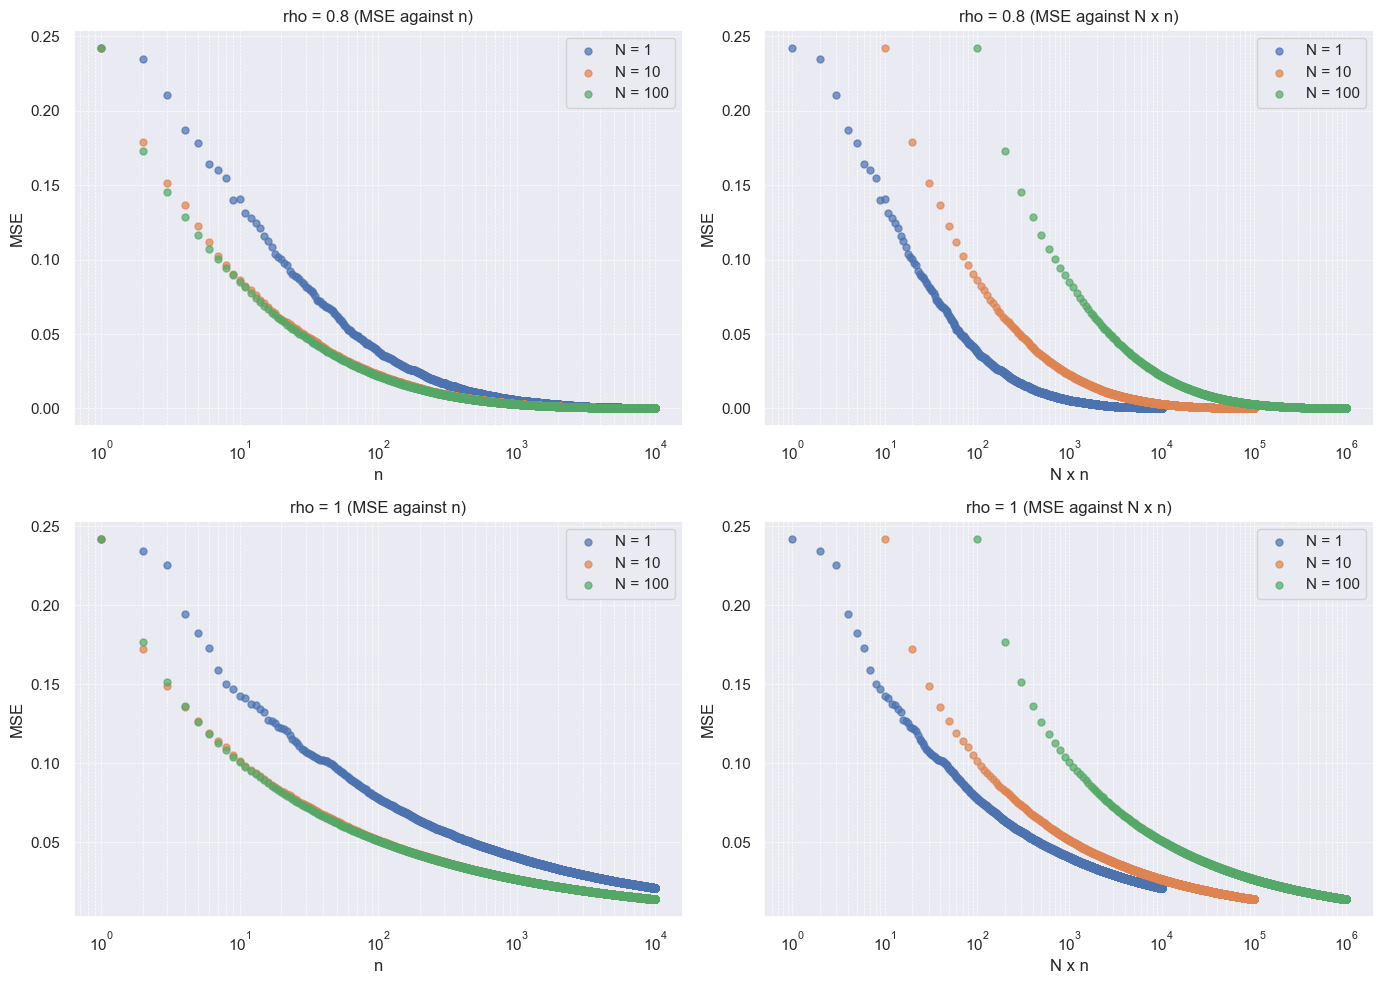

In [25]:
n = 10000
iterations = 100
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
# Setting seaborn style
sns.set(style="darkgrid")

# Create a 2x2 subplot using seaborn style
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for i, rho in enumerate([0.8, 1]):
    axes[i, 0].set_title(f'rho = {rho} (MSE against n)')
    axes[i, 1].set_title(f'rho = {rho} (MSE against N x n)')

    for N in [1, 10, 100]:
        all_sigma_estim = np.empty((iterations, n))
        for j in range(iterations):
            all_sigma_estim[j] = RM_European(n, N, rho, K, S0, T, r, I_market)
        MSE = np.mean((all_sigma_estim - sigma_opt)**2, axis=0)

        axes[i, 0].scatter(np.arange(1, n+1), MSE, label=f'N = {N}', s=25, alpha=0.7)
        axes[i, 1].scatter(N * np.arange(1, n+1), MSE, label=f'N = {N}', s=25, alpha=0.7)

        # Calculate convergence rate
        log_n_iterations = np.log(np.arange(1, n+1))
        log_errors = np.log(MSE)
        convergence_rate = -linregress(log_n_iterations, log_errors)[0]
        print(f'rho = {rho}, N = {N}, Convergence Rate: {convergence_rate}')

    # Setting labels, legends, and log scale for x-axis
    for ax in axes[i, :]:
        ax.set_xscale('log')
        ax.legend()
        ax.set_xlabel('n' if ax == axes[i, 0] else 'N x n')
        ax.set_ylabel('MSE')
        ax.grid(True, which="both", ls="--", linewidth=0.5)

plt.tight_layout()
plt.show()

Part 2: Asian Option 

Question 5: Find optimal volatility 

Understand the effect of each parameter in the algorithm

Rho is an agressiveness parameter. The algorithm stabilizes faster for rho=0.5 since the step size remains relatively large, but a lot of the variance in the estimation of Jhat(sigma) carries over to the algorithm's prediction of sigma_*

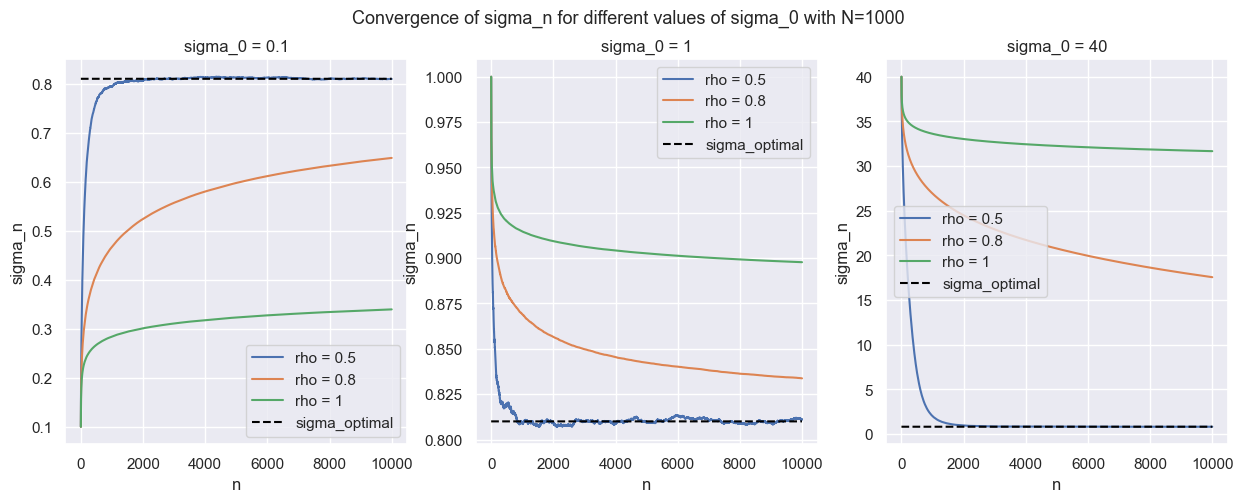

In [5]:
n = 10000
N,m = 1000,50
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigma_optimal = 0.81
full = np.full(n, sigma_optimal)

sigma_0_values = [0.1,1,40]
rho_values = [0.5,0.8,1]


sns.set(style="darkgrid")
fig, axes = plt.subplots(1,len(sigma_0_values), figsize=(15, 5))
fig.suptitle(f'Convergence of sigma_n for different values of sigma_0 with N={N}', fontsize=13)
for i, sigma_0 in enumerate(sigma_0_values):
    for j,rho in enumerate(rho_values):
        sigmas= RM_Asian(n, N, rho = rho, K = K, S0 = S0, T = T, r = r, I_market = I_market, m = m,sigma_0 = sigma_0)
        axes[i].plot(sigmas, label=f'rho = {rho}')
        axes[i].set_title(f'sigma_0 = {sigma_0}')
    axes[i].plot(full, label='sigma_optimal', color='black', linestyle='--')
    axes[i].legend()
    axes[i].set_xlabel('n')
    axes[i].set_ylabel('sigma_n')

plt.savefig('rho_influence.png', bbox_inches='tight')


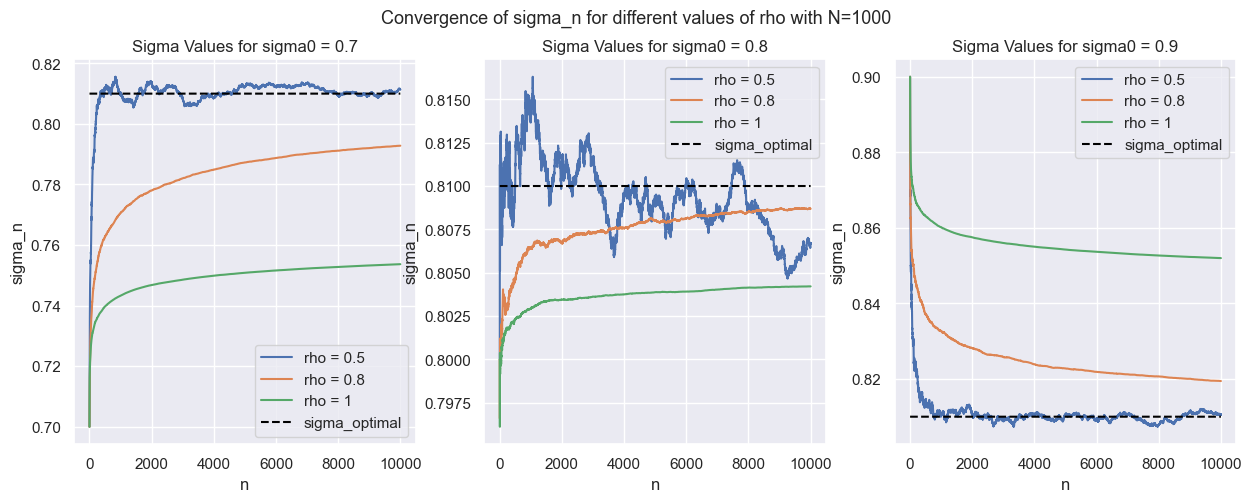

In [26]:
n = 10000
N,m = 1000,50
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
full = np.full(n, sigma_optimal)
sigma_0_values = [0.7,0.8,0.9]
rho_values = [0.5,0.8,1]

fig, axes = plt.subplots(1,len(sigma_0_values), figsize=(15, 5))
fig.suptitle(f'Convergence of sigma_n for different values of rho with N={N}', fontsize=13)
for i, sigma_0 in enumerate(sigma_0_values):
    for j,rho in enumerate(rho_values):
        sigmas= RM_Asian(n, N, rho = rho, K = K, S0 = S0, T = T, r = r, I_market = I_market, m = m,sigma_0 = sigma_0)
        axes[i].plot(sigmas, label=f'rho = {rho}')
        axes[i].set_title(f'Sigma Values for sigma0 = {sigma_0}')
    axes[i].plot(full, label='sigma_optimal', color='black', linestyle='--')
    axes[i].legend()
    axes[i].set_xlabel('n')
    axes[i].set_ylabel('sigma_n')

plt.savefig("steps.png", bbox_inches='tight')


N: number of sample for MC estimate of J

Result:
- no added benifit for N>2000, we still have a good amount of variance. Its not that detrimental to the algorithm. we can take N = 10000, but then it will be too slow
- The result with CLt Berry Essen sucks due to lognormality

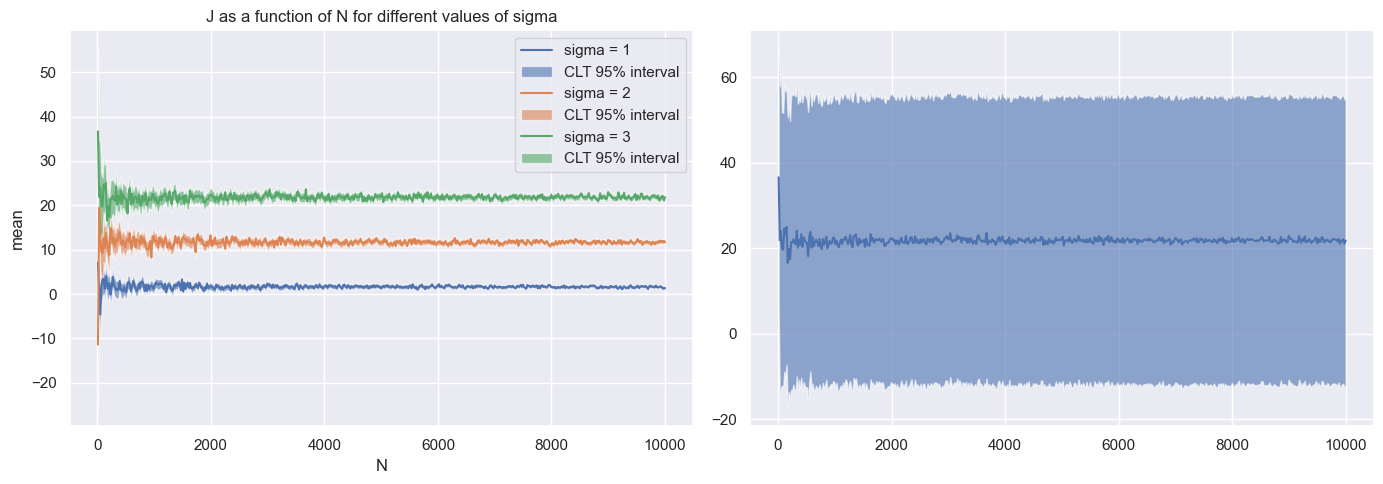

In [6]:
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
m = 50
sigma = [1,2,3]
N = np.linspace(10,10000,500,dtype=int)

mean = np.zeros(shape=(len(N), len(sigma)))
sdev = np.zeros(shape=(len(N), len(sigma)))

for i in range(len(N)):
    for j in range(len(sigma)):
        simulations = Simulate_Stock_Price(S0, sigma[j], r, T, m=m, N=N[i])
        avg_stock_prices = np.mean(simulations, axis=1)
        Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
        mean[i, j] = np.mean(Z)
        sdev[i, j] = np.std(Z)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i in range(len(sigma)):
    axes[0].plot(N, mean[:, i], label=f'sigma = {sigma[i]}')
    axes[0].fill_between(N, mean[:,i] - 1.96* sdev[:,i] / np.sqrt(N), mean[:,i] + 1.96*sdev[:,i] / np.sqrt(N), alpha=0.6, label=f"CLT 95% interval")

axes[0].legend()
axes[0].set_xlabel('N')
axes[0].set_ylabel('mean')
axes[0].set_title('J as a function of N for different values of sigma')

axes[1].plot(N, mean[:, i], label=f'sigma = {sigma[i]}')
axes[1].fill_between(N, mean[:,i] - sdev[:,i] , mean[:,i] + sdev[:,i] , alpha=0.6, label=f"CLT 95% interval")
plt.tight_layout()
plt.show()

Estimator J:

- standard deviation of the estimator is a sort of -x^2 curve

Text(0.5, 1.0, 'standard deviation of J estimator as a function of sigma')

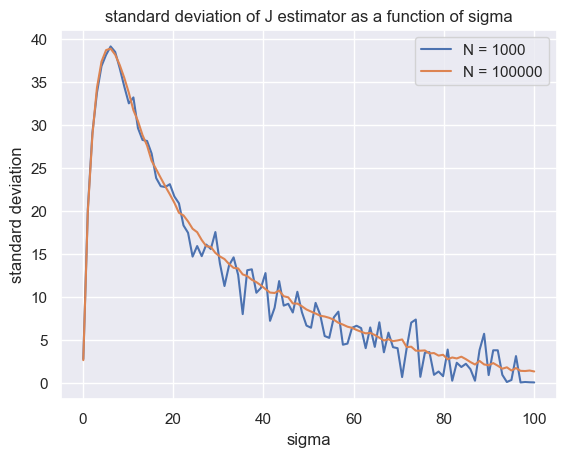

In [7]:
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
m = 50

N = [1000,100000]

sigma = np.linspace(0.1, 100, 100)
sdev = np.zeros(shape=(len(sigma),))

for j in range(len(N)):
    for i in range(len(sigma)):
        simulations = Simulate_Stock_Price(S0, sigma[i], r, T, m= m, N=N[j])
        avg_stock_prices = np.mean(simulations, axis=1)
        Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
        sdev[i] = np.std(Z)
    plt.plot(sigma, sdev, label='N = ' + str(N[j]))

plt.legend()
plt.xlabel('sigma')
plt.ylabel('standard deviation')
plt.title('standard deviation of J estimator as a function of sigma')


Just present CLT, yields same result as Berry Essen

Text(0.5, 1.0, 'Number of simulations (N) needed to have a 95% CLT confidence interval of length 1.0 of J with different values of sigma')

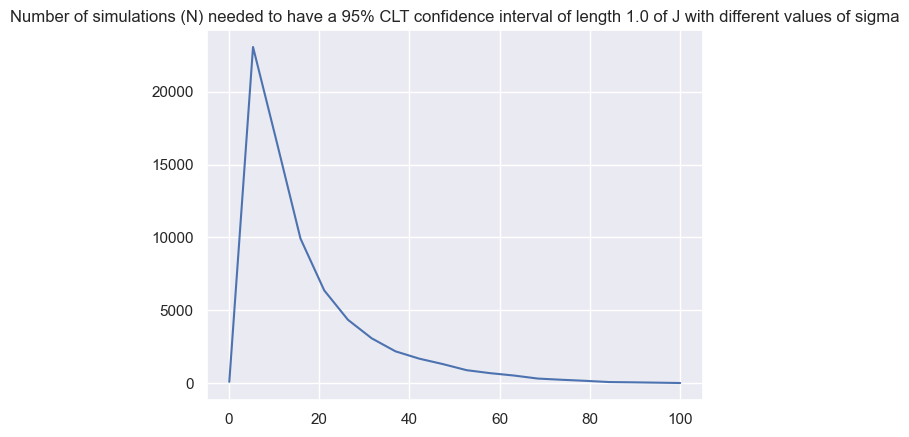

In [8]:
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
N,m = 100000,50
tol = 1/2

sigma_values = np.linspace(0.1, 100, 20)
St_dev = np.zeros(shape=(len(sigma_values),))

for i,sigma in enumerate(sigma_values):
    simulations = Simulate_Stock_Price(S0, sigma , r, T, m= 50, N=N)
    avg_stock_prices = np.mean(simulations, axis=1)
    Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
    St_dev[i] = np.std(Z)

plt.plot(sigma_values, ((1.96*St_dev/tol )**2))
plt.title(f"Number of simulations (N) needed to have a 95% CLT confidence interval of length {2*tol} of J with different values of sigma")


In [9]:
sigma = 0.8
N,m = 4000,50
alpha = 0.05
tol = 0.5

#Generate N simulations of the GBM
simulations = Simulate_Stock_Price(S0, sigma , r, T, m=50, N=N)
avg_stock_prices = np.mean(simulations, axis=1)
Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
Jhat = np.mean(Z)
Jhat_sd = np.std(Z)
Jhat_skew = st.skew(Z)

#Intervals
margin = 1.96 * Jhat_sd / np.sqrt(N)
lower_bound = Jhat - margin
upper_bound = Jhat + margin

print(f"CLT 95% Confidence Interval: ({lower_bound}, {upper_bound})")

margin = Jhat_sd / np.sqrt(alpha*N)
lower_bound = Jhat - margin
upper_bound = Jhat + margin
# Chebyshev
print(f"Chebyshev 95% Confidence Interval: ({lower_bound}, {upper_bound})")

k = 0.4748
xalpha = st.norm.ppf(k * Jhat_sd * Jhat_skew**3/(np.sqrt(N) *  Jhat_sd**3) + 1 - alpha/2)
margin = xalpha * Jhat_sd / np.sqrt(N)
lower_bound = Jhat - margin
upper_bound = Jhat + margin
# Barry-Essen
print(f"Barry-Essen 95% Confidence Interval: ({lower_bound}, {upper_bound})")

# Annexe
sigma = 1
N,m = 4000,50
alpha = 0.05
tol = 0.5

#Generate N simulations of the GBM
simulations = Simulate_Stock_Price(S0, sigma , r, T, m=50, N=N)
avg_stock_prices = np.mean(simulations, axis=1)
Z = np.exp(-r*T) * np.maximum(K - avg_stock_prices, 0) - I_market
Jhat = np.mean(Z)
Jhat_sd = np.std(Z)
Jhat_skew = st.skew(Z)


print(f"standard deviation for sigma={sigma} is {Jhat_sd}")
print(f"A 95% CLT confidence interval yields that we need {int((1.96*Jhat_sd/tol )**2)} simulations to have a 95% confidence interval of length {2*tol} for sigma = {sigma}")


CLT 95% Confidence Interval: (-0.754220509442421, 0.25810171458103026)
Chebyshev 95% Confidence Interval: (-1.4029682280685565, 0.9068494332071658)
Barry-Essen 95% Confidence Interval: (-0.7542135507235342, 0.2580947558621435)
standard deviation for sigma=1 is 18.817145456171456
A 95% CLT confidence interval yields that we need 5441 simulations to have a 95% confidence interval of length 1.0 for sigma = 1


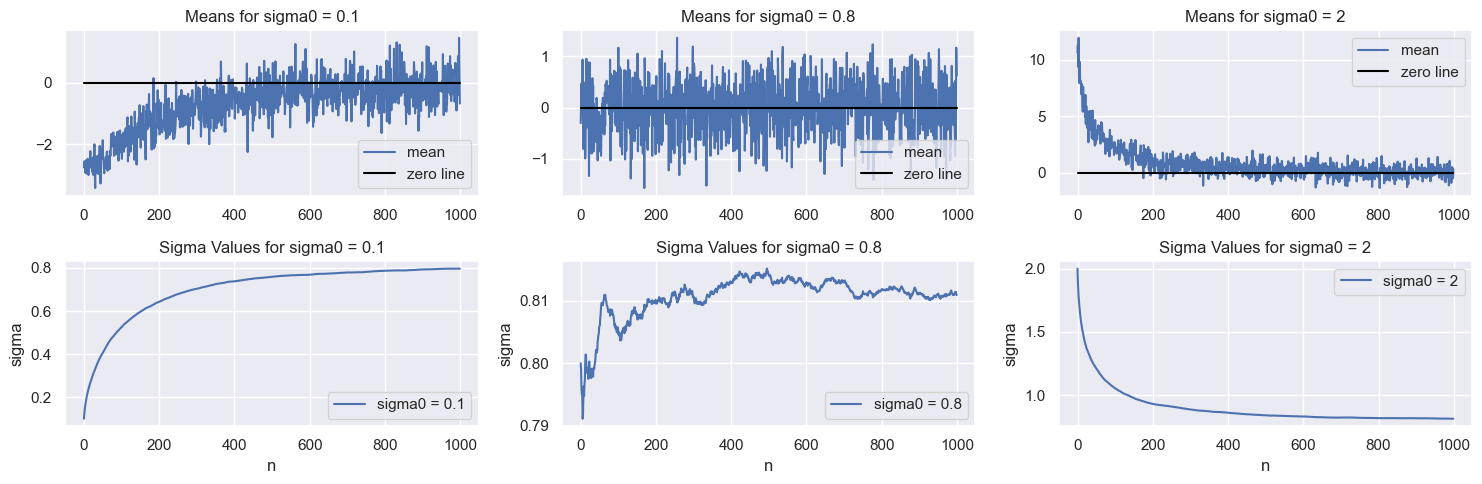

In [10]:
n = 1000
N,m = 1000,50
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22

rho = 0.5
sigma0_values = [0.1,0.8,2]


fig, axs = plt.subplots(2, 3, figsize=(15, 5))

for i, sigma0 in enumerate(sigma0_values):
    
    sigmas,means = RM_Asian_mean(n, N, rho = rho, K = K, S0 = S0, T = T, r = r, I_market = I_market, m = m,sigma_0 = sigma0)

    # Plotting means in the first column
    axs[0, i].plot(means, label='mean')
    axs[0, i].plot(np.zeros(shape=(n,)),color='black',label='zero line')
    axs[0, i].set_title(f'Means for sigma0 = {sigma0}')
    axs[0, i].legend()

    # Plotting sigma values in the third column
    axs[1, i].plot(range(n), sigmas, label=f'sigma0 = {sigma0}')
    axs[1, i].set_title(f'Sigma Values for sigma0 = {sigma0}')
    axs[1, i].legend()
    axs[1, i].set_xlabel('n')
    axs[1, i].set_ylabel('sigma')

plt.tight_layout()
plt.show()


Stopping criterion: As we can see from the analysis above, the algorithm should converge when Jhat(sigma) is close to 0. In order to create a robust stopping criterion, we take a window of size 1000 and measure the value of Jhat(sigma_n). When both Jhat(sigma_n) and the mean value of the Jhat(sigma_n) inside this window is close to 0, we stop the algorithm.

In [6]:
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
N,m,sigma0,rho = 1000,50,5, 0.5
window_size,tol1,tol2 = 1000,10**(-2),10**(-4)

itera = 1
H = np.zeros(shape=(itera,2))

for i in range(itera):
    a,b = RM_Asian_with_Stopping(N, rho = rho, K = K, S0 = S0, T = T, r = r, I_market = I_market, m = m,sigma_0 = sigma0,window_size= window_size,tol1=tol1,tol2=tol2)
    H[i,0] = a[-1]
    H[i,1] = b
print(f"Mean of sigma_n = {np.mean(H[:,0])}")
print(f"Standard deviation of sigma_n = {np.std(H[:,0])}")
print(f"mean of iterations = {np.mean(H[:,1])}")
print(f"standard deviation of iterations = {np.std(H[:,1])}")

2
4.619132724387417
3
4.384977651331165
4
4.200853305072597
5
4.0528973481254935
6
3.9256380333808996
7
3.810344620365449
8
3.708135588886019
9
3.6153125744835
10
3.534410855109058
11
3.45695289193979
12
3.382185175130678
13
3.3144541510218044
14
3.2469647618096107
15
3.1865554269659446
16
3.13481075976763
17
3.0850519862317065
18
3.028566032679732
19
2.981528804894309
20
2.933925701541874
21
2.889087945737829
22
2.8470199320977074
23
2.8085568310209763
24
2.768337586880192
25
2.7333526369703027
26
2.6945606894353595
27
2.6615459033482796
28
2.6284222454246353
29
2.595479730502201
30
2.5633719316840677
31
2.534613723640099
32
2.5039196692822268
33
2.4749939142034534
34
2.4487157236898525
35
2.4239146394903357
36
2.399464446323096
37
2.3735815349742277
38
2.350471338226283
39
2.328169656337115
40
2.305791433002984
41
2.2861885682927285
42
2.261896046001418
43
2.2403248434041054
44
2.2227708490049918
45
2.203193634908665
46
2.1832249345843033
47
2.164266860438539
48
2.147950364737743
49


Question 6: Importance Sampling

In [13]:
def calculate_bounds(r, T, S0, K, m):
    diff = K - S0 * np.mean(np.exp(r * np.arange(1,m+1) * T / m))
    diff = diff if diff > 0 else 0
    return str((np.exp(-r*T)*diff, np.exp(-r*T)*K))

print('Old bounds for I_market: ' + calculate_bounds(r=0.05, T=0.2, S0=100, K=120, m=50))
print('New bounds for I_market: ' + calculate_bounds(r=0.05, T=0.2, S0=100, K=80, m=50))

Old bounds for I_market: (19.294367043657672, 118.80598004990017)
New bounds for I_market: (0.0, 79.20398669993345)


In [14]:
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigma = 0.81
m = 50

mu_path = (1+np.exp(r*T) )/2 * S0

sd_N = np.sqrt( sigma ** 2 * T)
mu_N = np.log(mu_path) + (r-0.5*sigma**2) * T

print(f"The mean of GBM is { mu_path}")
print(f" 99% of the mass of the distribution is between {st.lognorm.ppf(0.05, scale = np.exp(mu_N), s = sd_N)} and {st.lognorm.ppf(0.995, scale = np.exp(mu_N), s = sd_N)}")

The mean of GBM is 100.5025083542084
 99% of the mass of the distribution is between 52.39105932634533 and 241.6882934126021


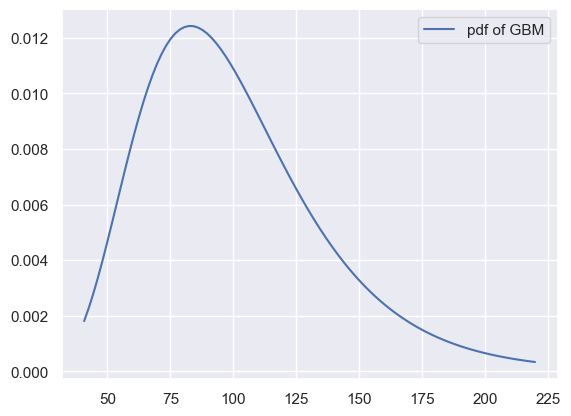

In [5]:
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigma = 0.81

mu_N = np.log(S0) + (r-0.5*sigma**2) * T
sd_N = np.sqrt( sigma ** 2 * T)

x = np.linspace(st.lognorm.ppf(0.01, scale = np.exp(mu_N), s = sd_N),st.lognorm.ppf(0.99, scale = np.exp(mu_N), s = sd_N),100)
z = st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N)
z2 = np.zeros(shape=(len(x)))
z2 = np.exp(-r*T) * np.maximum( 0,(K - x) )

plt.plot(x,z, label = "pdf of GBM")

plt.legend()
plt.show()


K = 120, (I_market=22 -> sigma = 0.81)

In [15]:
K, S0, r, T = 120, 100, 0.05, 0.2
I_market,m = 3, 50
sigma = 0.81
alpha = 0.05

mu_N = np.log(S0) + (r-0.5*sigma**2) * T
sd_N = np.sqrt( sigma ** 2 * T)

q = st.lognorm.ppf(1- alpha, scale = np.exp(mu_N), s = sd_N)
print(f" There is a {alpha} probability that the GBM is bigger than {q} with r = {r}")

print(f" 90% of the mass of the distribution is between {st.lognorm.ppf(0.05, scale = np.exp(mu_N), s = sd_N)} and {st.lognorm.ppf(0.95, scale = np.exp(mu_N), s = sd_N)}")

#Modify the interest rate
r_tilde = -1.7

mu_N_tilde = np.log(S0) + (r_tilde-0.5*sigma**2) * T

q = st.lognorm.ppf(1-alpha, scale = np.exp(mu_N_tilde), s = sd_N)

print(f" There is a {alpha} probability that the GBM is bigger than {q} with r_tilde = {r_tilde}") 

 There is a 0.05 probability that the GBM is bigger than 171.6395981182253 with r = 0.05
 90% of the mass of the distribution is between 52.1291062126526 and 171.6395981182253
 There is a 0.05 probability that the GBM is bigger than 120.95238051801978 with r_tilde = -1.7


Actually I want to approximate f(x)*p(x)

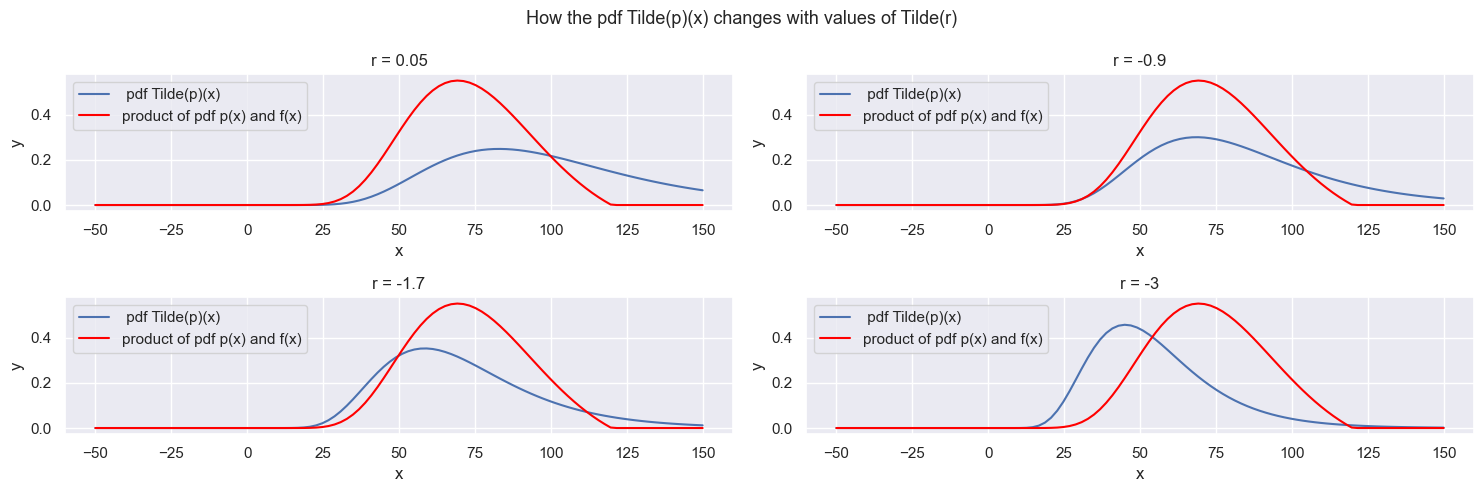

In [16]:
K, S0, r, T, I_market = 120, 100, 0.05, 0.2, 22
sigma = 0.81

#f
x = np.linspace(-50,150,100)
y = np.exp(-r*T)*np.maximum( 0,(K - x) )
#p
mu_N = np.log(S0) + (r-0.5*sigma**2) * T
sd_N = np.sqrt( sigma ** 2 * T)
z = st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N) 
#f*p
g = z * y 

r_values = [0.05,-0.9,-1.7,-3]

sns.set(style="darkgrid")

fig, axes = plt.subplots(2,2,figsize=(15, 5))
fig.suptitle(f'How the pdf Tilde(p)(x) changes with values of Tilde(r)', fontsize=13)
for i, r in enumerate(r_values):
    mu_N_tilde = np.log(S0) + (r-0.5*sigma**2) * T
    z_tilde = st.lognorm.pdf(x, scale = np.exp(mu_N_tilde), s = sd_N)

    axes[i//2,i%2].plot(x,20 *z_tilde, label = f" pdf Tilde(p)(x)")
    axes[i//2,i%2].plot(x,g, label = f"product of pdf p(x) and f(x)", color= "red")
    axes[i//2,i%2].legend()
    axes[i//2,i%2].set_title(f"r = {r_values[i]}")
    axes[i//2,i%2].set_xlabel("x")
    axes[i//2,i%2].set_ylabel("y")
plt.tight_layout()

plt.savefig("Tilde(r)1.png", bbox_inches='tight')


Let us compute the mean value of f(x)*p(x)


The mean of g is 76.34126341263412


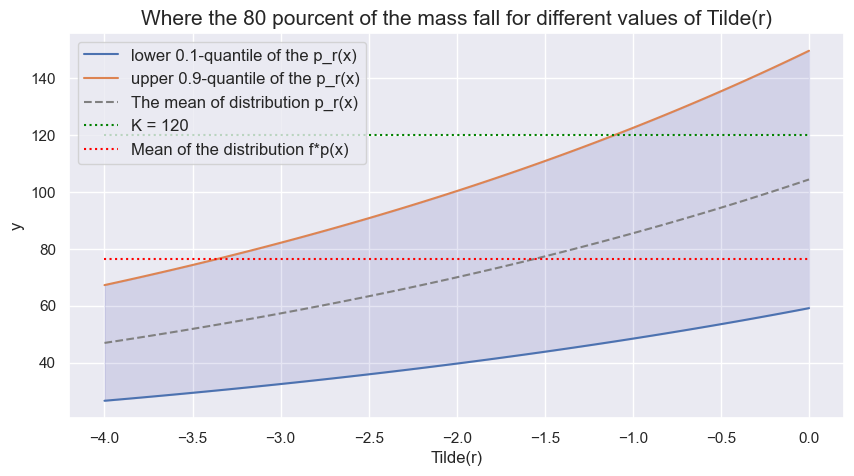

In [17]:
K, S0, r, T, I_market = 120, mu_path, 0.05, 0.2, 22
sigma = 0.81
alpha = 0.1
# Retrieve the max of f * p, which is in between 0 and 100 and it is the mean of this new pdf called g

#f
khi = np.linspace(0,100,100000)
f = np.exp(-r*T)*np.maximum( 0,(K - khi) ) 

#p
x = np.linspace(-50,150,100000)
mu_N = np.log(S0) + (r-0.5*sigma**2) * T
sd_N = np.sqrt( sigma ** 2 * T)
p = st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N)  
#f*p
g = f * p 
#max of f*p
mu_g = x[np.argmax(g)]
print(f"The mean of g is {mu_g}")

#Plotting
r = np.linspace(-4,0,100)
sd_N = np.sqrt( sigma ** 2 * T)

y1 = []
y2 = []
ligne_k = np.full(100,K)
ligne_mu_g = np.full(100,mu_g)

for i in range(100):

    mu_N = np.log(mu_path) + (r[i]-0.5*sigma**2) * T
    y1 = np.append(y1,st.lognorm.ppf(alpha, scale = np.exp(mu_N), s = sd_N))
    y2 = np.append(y2,st.lognorm.ppf(1-alpha, scale = np.exp(mu_N), s = sd_N))

y3 = (y1+y2)/2
plt.figure(figsize=(10, 5))
plt.plot(r,y1, label = f"lower {alpha}-quantile of the p_r(x)")
plt.plot(r,y2, label = f"upper {1-alpha}-quantile of the p_r(x)")
plt.fill_between(r, y1, y2, color='darkblue', alpha=0.1)
plt.plot(r,y3, label = "The mean of distribution p_r(x)", color="grey",linestyle='--')
plt.plot(r,ligne_k, label = f"K = {K}",color="green",linestyle='dotted')
plt.plot(r,ligne_mu_g, label = "Mean of the distribution f*p(x)",color="red",linestyle='dotted')
plt.title("Where the 80 pourcent of the mass fall for different values of Tilde(r)",fontsize=15)
plt.xlabel("Tilde(r)")
plt.ylabel("y")
plt.legend(fontsize=12)
plt.savefig("graph(r)1.png", bbox_inches='tight')

K = 80, I_market = 22 -> sigma in the range of 1.18/1.22
Idea obtain first guess not too far with neg and assume its the real for a sort of idea IS 

In [20]:
K, S0, r, T = 80, mu_path, 0.05, 0.2
I_market,m = 3, 50
sigma_0 = 5
sigma,i =  Sign_changing(K,S0,T,r,I_market,m,sigma_0)
print(sigma)
alpha = 0.1

mu_N = np.log(S0) + (r-0.5*sigma**2) * T
sd_N = np.sqrt( sigma ** 2 * T)

q = st.lognorm.ppf(1-alpha, scale = np.exp(mu_N), s = sd_N)
print(f" There is a {alpha} probability that the GBM is bigger than {q} with r = {r}")

print(f" 90% of the mass of the distribution is between {st.lognorm.ppf(0.05, scale = np.exp(mu_N), s = sd_N)} and {st.lognorm.ppf(0.95, scale = np.exp(mu_N), s = sd_N)}")

#Modify the interest rate
r_tilde = -4.8

mu_N_tilde = np.log(S0) + (r_tilde-0.5*sigma**2) * T

q = st.lognorm.ppf(1-alpha, scale = np.exp(mu_N_tilde), s = sd_N)

print(f" There is a {alpha} probability that the GBM is bigger than {q} with r_tilde = {r_tilde}") 

1.2097995404425945
 There is a 0.1 probability that the GBM is bigger than 175.42126631508256 with r = 0.05
 90% of the mass of the distribution is between 36.01341676062194 and 213.52433969811858
 There is a 0.1 probability that the GBM is bigger than 66.49922658266686 with r_tilde = -4.8


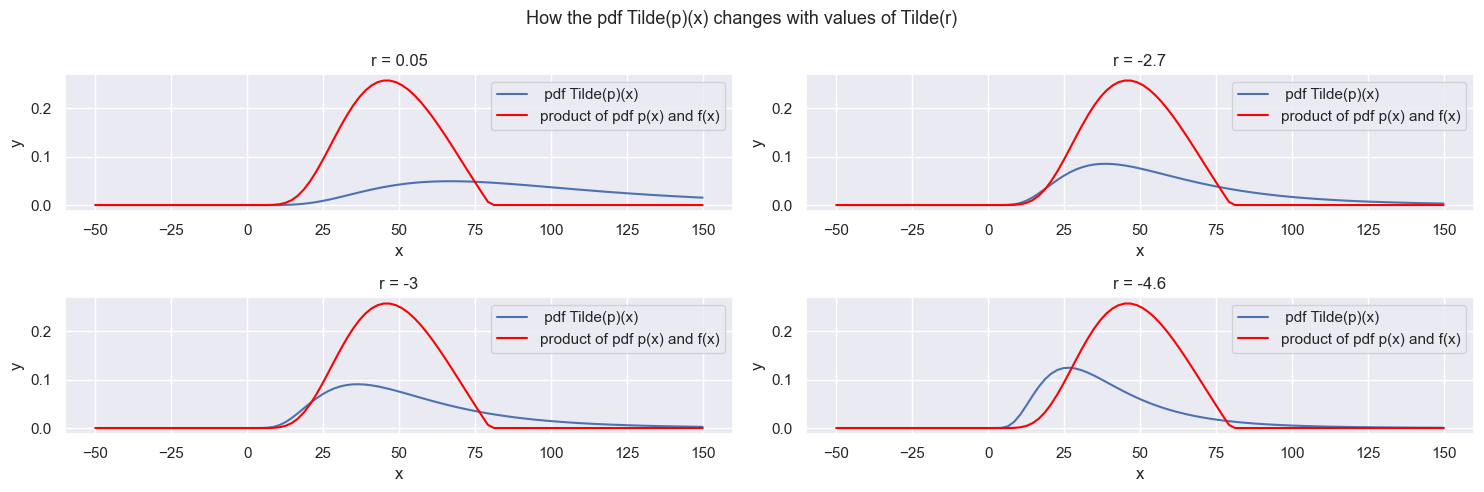

In [21]:
K, S0, r, T = 80, mu_path, 0.05, 0.2
I_market,m = 3, 50
sigma = 1.18
alpha = 0.05

mu_N = np.log(S0) + (r-0.5*sigma**2) * T
sd_N = np.sqrt( sigma ** 2 * T)
#f
x = np.linspace(-50,150,100)
y = np.exp(-r*T)*np.maximum( 0,(K - x) )
#p
mu_N = np.log(S0) + (r-0.5*sigma**2) * T
sd_N = np.sqrt( sigma ** 2 * T)
z = st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N) 
#f*p
g = z * y 

r_values = [0.05,-2.7,-3,-4.6]

sns.set(style="darkgrid")

fig, axes = plt.subplots(2,2,figsize=(15, 5))
fig.suptitle(f'How the pdf Tilde(p)(x) changes with values of Tilde(r)', fontsize=13)
for i, r in enumerate(r_values):
    mu_N_tilde = np.log(S0) + (r-0.5*sigma**2) * T
    z_tilde = st.lognorm.pdf(x, scale = np.exp(mu_N_tilde), s = sd_N)

    axes[i//2,i%2].plot(x, 5*z_tilde, label = f" pdf Tilde(p)(x)")
    axes[i//2,i%2].plot(x,g, label = f"product of pdf p(x) and f(x)", color= "red")
    axes[i//2,i%2].legend()
    axes[i//2,i%2].set_title(f"r = {r_values[i]}")
    axes[i//2,i%2].set_xlabel("x")
    axes[i//2,i%2].set_ylabel("y")
plt.tight_layout()

plt.savefig("Tilde(r)1.png", bbox_inches='tight')

The mean of g is 51.87701877018769


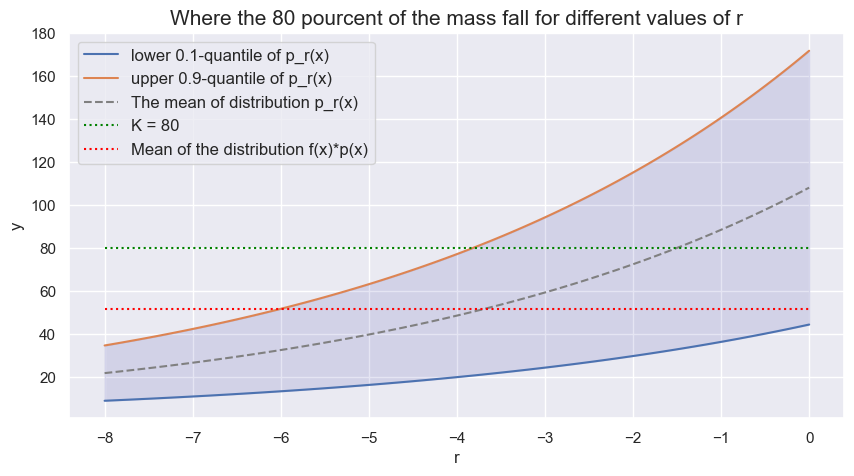

In [22]:
K, S0, r, T = 80, 100, 0.05, 0.2
I_market,m = 3, 50
sigma = 1.18
alpha = 0.1
mu_N = np.log(S0) + (r-0.5*sigma**2) * T
sd_N = np.sqrt( sigma ** 2 * T)

# Retrieve the max of f * p, which is in between 0 and 100 and it is the mean of this new pdf called g

#f
khi = np.linspace(0,100,100000)
f = np.exp(-r*T)*np.maximum( 0,(K - khi) ) 

#p
x = np.linspace(-50,150,100000)
mu_N = np.log(S0) + (r-0.5*sigma**2) * T
sd_N = np.sqrt( sigma ** 2 * T)
p = st.lognorm.pdf(x, scale = np.exp(mu_N), s = sd_N)  
#f*p
g = f * p 
#max of f*p
mu_g = x[np.argmax(g)]
print(f"The mean of g is {mu_g}")

#Plotting
r = np.linspace(-8,0,100)
sd_N = np.sqrt( sigma ** 2 * T)

y1 = []
y2 = []
ligne_k = np.full(100,K)
ligne_mu_g = np.full(100,mu_g)

for i in range(100):

    mu_N = np.log(mu_path) + (r[i]-0.5*sigma**2) * T
    y1 = np.append(y1,st.lognorm.ppf(alpha, scale = np.exp(mu_N), s = sd_N))
    y2 = np.append(y2,st.lognorm.ppf(1-alpha, scale = np.exp(mu_N), s = sd_N))

y3 = (y1+y2)/2
plt.figure(figsize=(10, 5))
plt.plot(r,y1, label = f"lower {alpha}-quantile of p_r(x)")
plt.plot(r,y2, label = f"upper {1-alpha}-quantile of p_r(x)")
plt.fill_between(r, y1, y2, color='darkblue', alpha=0.1)
plt.plot(r,y3, label = "The mean of distribution p_r(x)", color="grey",linestyle='--')
plt.plot(r,ligne_k, label = f"K = {K}",color="green",linestyle='dotted')
plt.plot(r,ligne_mu_g, label = "Mean of the distribution f(x)*p(x)",color="red",linestyle='dotted')
plt.title("Where the 80 pourcent of the mass fall for different values of r",fontsize=15)
plt.xlabel("r")
plt.ylabel("y")
plt.legend(fontsize=12)
plt.savefig("Graph(r)2.png", bbox_inches='tight')

7 and Part b:

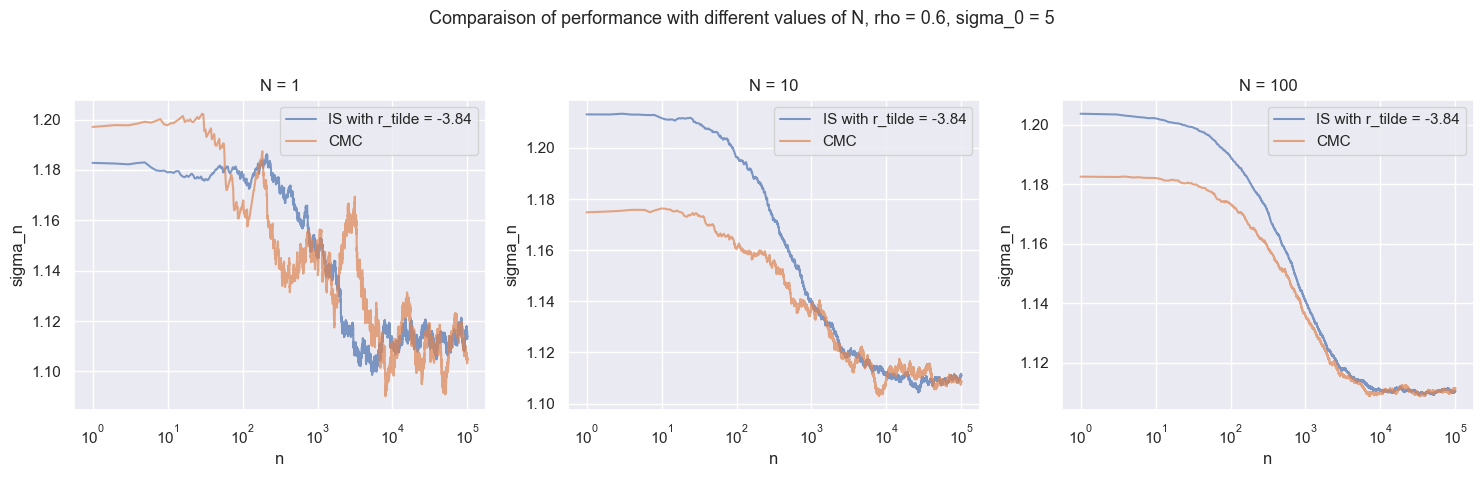

In [13]:
#Parameters
K, S0, T, r, m = 80, 100, 0.2, 0.05, 50
I_market,n,rho = 3,None, 0.6
sigma_0 = 5
sigma_opt = 1.1

N_values = [1,10,100]

r_tilde = function_r_tilde(K, S0, T, r, I_market, m, sigma_0)

#Plot 
sns.set(style="darkgrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f'Comparaison of performance with different values of N, rho = {rho}, sigma_0 = {sigma_0}', fontsize=13)


for i, N in enumerate(N_values):
    ax = axes[i]  # Determine the position of the subplot

    # Assuming RM_Asian_with_Stopping and RM_Asian_with_IS are defined elsewhere
    sigmas, it = RM_Asian_with_Stopping(N, rho, K, S0, T, r, I_market, m, sigma_0)
    sigmas_IS, it_IS = RM_Asian_with_IS(n, N, rho, K, S0, T, r, r_tilde, I_market, m, sigma_0)

    ax.plot(range(1, len(sigmas_IS) + 1), sigmas_IS, label=f"IS with r_tilde = {r_tilde:.2f}", alpha=0.7)
    ax.plot(range(1, len(sigmas) + 1), sigmas, label="CMC", alpha=0.7)
    ax.plot(range(1, len(sigmas) + 1), np.full(len(sigmas), sigma_opt), label="sigma_opt", color="black", linestyle='--')
    ax.set_title(f'N = {N}')
    ax.set_xlabel('n')
    ax.set_ylabel('sigma_n')
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout
plt.show()




Just to show you I have a good r_tile 

Stopped at iteration n = 23587, where sigma_n = 1.1084020329753257
Stopped at iteration n = 695271, where sigma_n = 1.1113870576441454
Stopped at iteration n = 157159, where sigma_n = 1.1129644619223076
Stopped at iteration n = 98526, where sigma_n = 1.1093750457897937
Stopped at iteration n = 143824, where sigma_n = 1.115429707289038


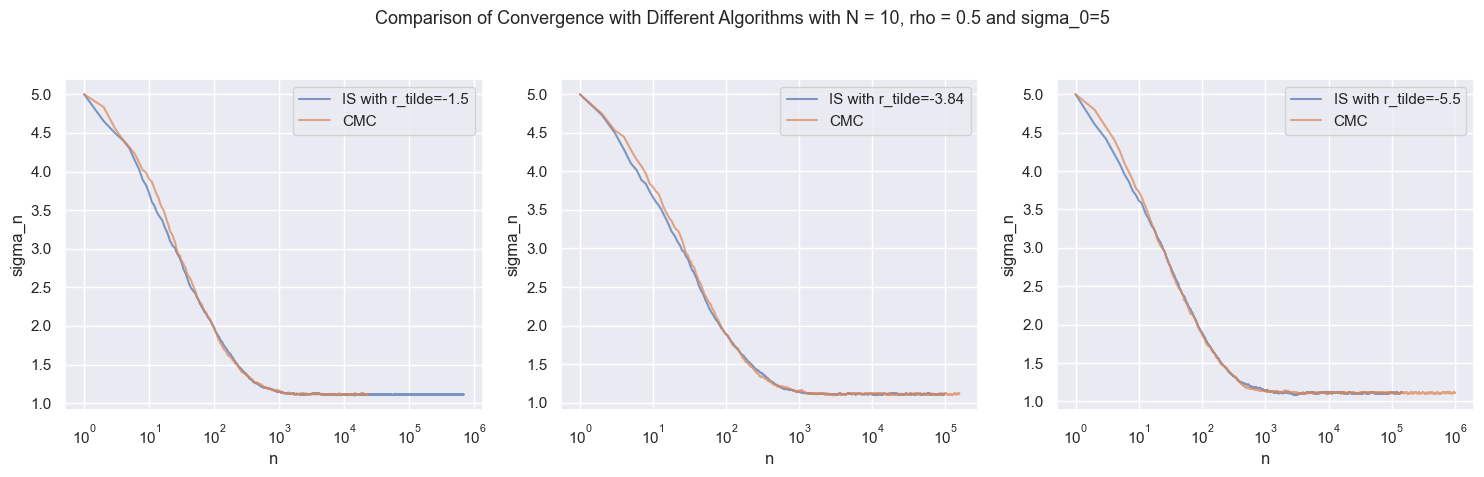

In [5]:
#Parameters
K, S0, T, r, m = 80, 100, 0.2, 0.05, 50
I_market,n,N,rho = 3,None, 10, 0.5
r_tilde = [-1.5,-3.84,-5.5]
sigma_0 = 5

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle(f'Comparison of Convergence with Different Algorithms with N = {N}, rho = {rho} and sigma_0={sigma_0}', fontsize=13)

for i, rt in enumerate(r_tilde):
    ax = axes[i]  # Determine the position of the subplot

    # Assuming RM_Asian_with_Stopping and RM_Asian_with_IS are defined elsewhere
    sigmas, it = RM_Asian_with_Stopping(N, rho, K, S0, T, r, I_market, m, sigma_0)
    sigmas_IS, it_IS = RM_Asian_with_IS(n, N, rho, K, S0, T, r, rt, I_market, m, sigma_0)

    ax.plot(range(1, len(sigmas_IS) + 1), sigmas_IS, label=f"IS with r_tilde={rt}", alpha=0.7)
    ax.plot(range(1, len(sigmas) + 1), sigmas, label="CMC", alpha=0.7)
    ax.set_xlabel('n')
    ax.set_ylabel('sigma_n')
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout
plt.show()

In [6]:
#Parameters
K, S0, T, r, m, N = 80, 100, 0.2, 0.05, 50,100
I_market,n,rho = 3,None, 0.5
sigma_0 = 5
r_tilde = function_r_tilde(K, S0, T, r, I_market, m, sigma_0)
tol1,tol2 = 10**(-4),10**(-4)

itera = 10
Q = np.zeros(shape=(itera,2))

for i in range(itera):
    print(i)
    c,d = RM_Asian_with_IS(n, N, rho = rho, K = K, S0 = S0, T = T, r = r, r_tilde = r_tilde, I_market = I_market, m = m,sigma_0 = sigma_0,window_size= window_size,tol1=tol1,tol2=tol2)
    Q[i,0] = c[-1]
    Q[i,1] = d



0
Stopped at iteration n = 35831, where sigma_n = 1.110253957105403
1
Stopped at iteration n = 217226, where sigma_n = 1.109961241764031
2
Stopped at iteration n = 149062, where sigma_n = 1.1103043189532544
3
Stopped at iteration n = 23925, where sigma_n = 1.1102525952900815
4
5
6
Stopped at iteration n = 368866, where sigma_n = 1.1105546780335989
7
Stopped at iteration n = 378040, where sigma_n = 1.1100129317451115
8
Stopped at iteration n = 27901, where sigma_n = 1.1086087997662628
9


In [7]:
print(f"Mean of sigma_n = {np.mean(Q[:,0])}")
print(f"Standard deviation of sigma_n = {np.std(Q[:,0])}")
print(f"mean of iterations = {np.mean(Q[:,1])}")
print(f"standard deviation of iterations = {np.std(Q[:,1])}")

Mean of sigma_n = 1.1099829110632204
Standard deviation of sigma_n = 0.000499803852052052
mean of iterations = 420085.1
standard deviation of iterations = 398284.1701653356


In [2]:
#Parameters
K, S0, T, r, m, N = 80, 100, 0.2, 0.05, 50,100
I_market,n,rho = 3,None, 0.5
sigma_0 = 5

window_size,tol1,tol2 = 1000,10**(-2),10**(-4)
r_tilde = function_r_tilde(K, S0, T, r, I_market, m, sigma_0)

itera = 1
H = np.zeros(shape=(itera,2))
Q = np.zeros(shape=(itera,2))

for i in range(itera):
    print(i)
    a,b = RM_Asian_with_Stopping(N, rho = rho, K = K, S0 = S0, T = T, r = r, I_market = I_market, m = m,sigma_0 = sigma_0,window_size= window_size,tol1=tol1,tol2=tol2)
    H[i,0] = a[-1]
    H[i,1] = b
    c,d = RM_Asian_with_IS(n, N, rho = rho, K = K, S0 = S0, T = T, r = r, r_tilde = r_tilde, I_market = I_market, m = m,sigma_0 = sigma_0,window_size= window_size,tol1=tol1,tol2=tol2)
    Q[i,0] = c[-1]
    Q[i,1] = d

0


NameError: name 'r_tilde' is not defined

In [18]:
print(f"Mean of sigma_n = {np.mean(H[:,0])}")
print(f"Standard deviation of sigma_n = {np.std(H[:,0])}")
print(f"mean of iterations = {np.mean(H[:,1])}")
print(f"standard deviation of iterations = {np.std(H[:,1])}")

print(f"Mean of sigma_n = {np.mean(Q[:,0])}")
print(f"Standard deviation of sigma_n = {np.std(Q[:,0])}")
print(f"mean of iterations = {np.mean(Q[:,1])}")
print(f"standard deviation of iterations = {np.std(Q[:,1])}")

Mean of sigma_n = 1.1112172084647582
Standard deviation of sigma_n = 0.0
mean of iterations = 100000.0
standard deviation of iterations = 0.0
Mean of sigma_n = 1.1101482517758072
Standard deviation of sigma_n = 0.0
mean of iterations = 100000.0
standard deviation of iterations = 0.0


Question 7:

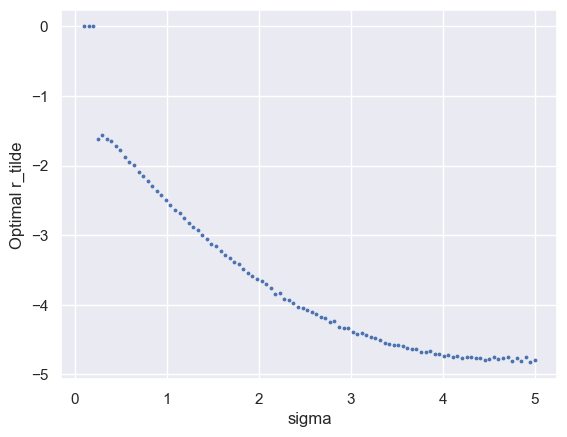

In [ ]:
K, S0, T, r = 80, 100, 0.2, 0.05
m = 50
N = 100000    
sigmas = np.linspace(0.1, 5, num=100)
result = find_optimal_r_tilde(sigmas, S0, K, r, T, m, N)
plt.scatter(sigmas, result, s=3)
plt.xlabel('sigma')
plt.ylabel('Optimal r_tilde')

# Spline interpolation
spline_interp = interp1d(sigmas, result, kind='cubic')

In [ ]:
n, N, rho = 10**4, 10, 0.6
K, S0, T, r, I_market = 80, 100, 0.2, 0.05, 3
r_tilde = -2.6
sigma_0 = 1
m = 50

sigmas_IS_opt = RM_Asian_with_IS_opt(n, N, rho, K, S0, T, r, I_market, m,sigma_0)
sigmas_IS = RM_Asian_with_IS(n, N, rho, K, S0, T, r, r_tilde, I_market, m,sigma_0)
sigmas = RM_Asian(n, N, rho, K, S0, T, r, I_market, m,sigma_0)

TypeError: RM_Asian_with_IS_opt() missing 2 required positional arguments: 'sigmas' and 'result'

In [ ]:
plt.plot(range(30,len(sigmas_IS_opt)), sigmas_IS_opt[30:], label="with IS and optimal r_tilde", alpha=0.7)
plt.plot(range(30,len(sigmas_IS)), sigmas_IS[30:], label="with IS", alpha=0.7)
plt.plot(range(30,len(sigmas)), sigmas[30:], label="without IS", alpha=0.7)

plt.xlabel('n')
plt.ylabel('sigma')
plt.legend()

plt.xscale('log')

In [ ]:
window_size = 5000
variance_analyzer = VarianceAnalyzer(window_size)

variance_1 = [variance_analyzer.update(value) for value in sigmas_IS_opt]
variance_2 = [variance_analyzer.update(value) for value in sigmas_IS]
variance_3 = [variance_analyzer.update(value) for value in sigmas]

plt.plot(range(window_size, len(variance_1)), variance_1[window_size:], label='with IS and optimal r_tilde', alpha=0.7)
plt.plot(range(window_size, len(variance_2)), variance_2[window_size:], label='with IS', alpha=0.7)
plt.plot(range(window_size, len(variance_3)), variance_3[window_size:], label='without IS', alpha=0.7)

plt.xlabel('Iterations')
plt.ylabel('Variance')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

NameError: name 'VarianceAnalyzer' is not defined